In [1]:
import kaggle

In [2]:
!/home/gguser01/.venvs/vfastai/bin/kaggle competitions download -c digit-recognizer

digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [30]:
import zipfile, torch, math, os, PIL

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [151]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu'); device

device(type='cpu')

In [4]:
zf = zipfile.ZipFile('digit-recognizer.zip'); zf.filelist

In [152]:
train_df = pd.read_csv(zf.open('train.csv'), dtype='float32')
test_df = pd.read_csv(zf.open('test.csv'), dtype='float32')

In [153]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [324]:
class mnist_dataset(torch.utils.data.Dataset):
    
    def __init__(self, data, transform=None, linear=True):
        self.data = data
        self.transform = transform
        self.linear = linear
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):

        img = self.data.iloc[idx].iloc[1:].div(255).to_numpy()
        lbl = train_df.iloc[idx].label
        
        if not self.linear: img = img.reshape(1, 28, 28)
            
        if self.transform: img = self.transform(img)

        return img, lbl

In [239]:
#https://discuss.pytorch.org/t/whats-the-difference-between-torch-reshape-vs-torch-view/159172
#reshape will return a view if possible and will trigger a copy otherwise as explained in the docs 108. If in doubt, you can use reshape if you do not explicitly expect a view of the tensor.
#A view points to the same data stored in memory using a changed meta-data such as its shape and stride.
x = torch.randn(2, 4); print('x', x.size(), x.stride(), x.is_contiguous())
y = x.view(-1); print('y', y.size(), y.stride(), y.is_contiguous())

w = torch.randn(2, 4, 8); print('w', w.size(), w.stride(), w.is_contiguous())
z = w[:, ::2]; print('z', z.size(), z.stride(), z.is_contiguous())
#z1 = z.view(-1) RuntimeError: view size is not compatible with input tensor's size...
z2 = z.reshape(-1); print('z2', z2.size(), z2.stride(), z2.is_contiguous())

x torch.Size([2, 4]) (4, 1) True
y torch.Size([8]) (1,) True
w torch.Size([2, 4, 8]) (32, 8, 1) True
z torch.Size([2, 2, 8]) (32, 16, 1) False
z2 torch.Size([32]) (1,) True


In [328]:
torch.from_numpy(train_df.iloc[0].iloc[1:].div(255).values).view(1, 28, 28)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [329]:
mnist_ds = mnist_dataset(train_df); len(train_data)
mnist_ds_conv = mnist_dataset(train_df, linear=False)

In [168]:
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed = 42

generator = torch.Generator().manual_seed(random_seed)

validation_size = int(len(mnist_ds) * validation_split)
train_size = len(mnist_ds) - validation_size

train_dataset, validation_dataset = torch.utils.data.random_split(
    mnist_ds,
    [train_size, validation_size],
    generator=generator
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=shuffle_dataset
)
validation_dataloader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=shuffle_dataset
)

In [169]:
print(len(train_dataset), len(validation_dataset))

33600 8400


In [170]:
train_features, train_labels = next(iter(train_dataloader))
val_features, val_labels = next(iter(validation_dataloader))

print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
print(f'Data in the batch: {train_features}')

Feature batch shape: torch.Size([64, 784])
Labels batch shape: torch.Size([64])
Data in the batch: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


tensor(7.)

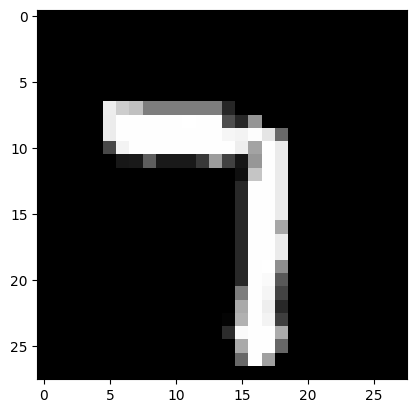

In [330]:
plt.imshow(train_features[idx].reshape(28, 28, 1), cmap='gray'); train_labels[idx]

tensor(8.)

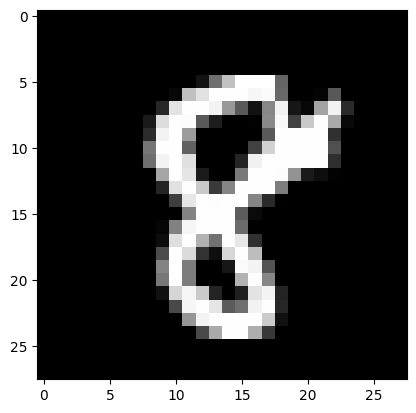

In [331]:
plt.imshow(val_features[idx].reshape(28, 28, 1), cmap='gray'); val_labels[idx]

In [187]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):
    
    #import ipdb; ipdb.set_trace()
    
    for epoch in range(num_epochs):
        
        model.train()

        loss_accum = 0
        correct_samples = 0
        total_samples = 0

        for i_step, (x, y) in enumerate(train_loader):
            
            x = x.to(device)
            y = y.long().to(device)
            
            prediction = model(x)
            loss_value = loss(prediction, y)
            
            loss_value.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]

            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_acc = float(correct_samples) / total_samples
        val_acc = compute_accuracy(model, val_loader)

        print("Epoch: %i/%i, Average Loss: %f, Train acc: %f, Val acc: %f" %
            (epoch + 1, num_epochs, ave_loss, train_acc, val_acc)
        )

In [188]:
def compute_accuracy(model, loader):

    model.eval()
    
    correct_samples, total_samples = 0, 0

    with torch.no_grad():

        for i, (inputs, labels) in enumerate(loader):
            x = inputs.to(device)
            y = labels.to(device)

            output = model(x)
            prediction = torch.argmax(output, axis=1)
        
            correct_samples += torch.sum(prediction == y)
            total_samples += y.shape[0]

    return correct_samples / total_samples

In [ ]:
#linear

In [207]:
model_0 = torch.nn.Linear(28 * 28, 10)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=.5)

In [208]:
train_model(model_0, train_dataloader, validation_dataloader, loss, optimizer, 10)

Epoch: 1/10, Average Loss: 0.408749, Train acc: 0.882381, Val acc: 0.906548
Epoch: 2/10, Average Loss: 0.308169, Train acc: 0.911190, Val acc: 0.910119
Epoch: 3/10, Average Loss: 0.290119, Train acc: 0.916964, Val acc: 0.911310
Epoch: 4/10, Average Loss: 0.280228, Train acc: 0.920298, Val acc: 0.909405
Epoch: 5/10, Average Loss: 0.272925, Train acc: 0.922589, Val acc: 0.912738
Epoch: 6/10, Average Loss: 0.267821, Train acc: 0.923661, Val acc: 0.913333
Epoch: 7/10, Average Loss: 0.263928, Train acc: 0.924345, Val acc: 0.915238
Epoch: 8/10, Average Loss: 0.259738, Train acc: 0.925685, Val acc: 0.912976
Epoch: 9/10, Average Loss: 0.256323, Train acc: 0.925923, Val acc: 0.909286
Epoch: 10/10, Average Loss: 0.253960, Train acc: 0.927381, Val acc: 0.914048


In [277]:
#convs

In [332]:
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed = 42

generator = torch.Generator().manual_seed(random_seed)

validation_size = int(len(mnist_ds_conv) * validation_split)
train_size = len(mnist_ds_conv) - validation_size

train_dataset_conv, validation_dataset_conv = torch.utils.data.random_split(
    mnist_ds_conv,
    [train_size, validation_size],
    generator=generator
)

train_dataloader_conv = torch.utils.data.DataLoader(
    train_dataset_conv, 
    batch_size=batch_size, 
    shuffle=shuffle_dataset
)
validation_dataloader_conv = torch.utils.data.DataLoader(
    validation_dataset_conv,
    batch_size=batch_size,
    shuffle=shuffle_dataset
)

In [333]:
next(iter(train_dataloader_conv))[0].size()

torch.Size([64, 1, 28, 28])

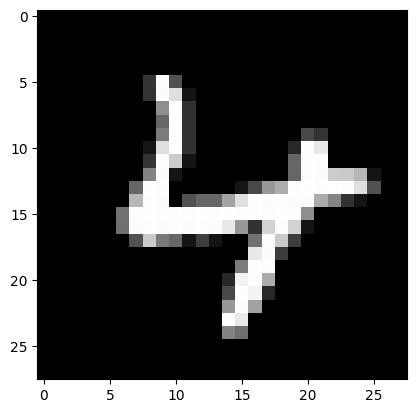

In [335]:
plt.imshow(next(iter(train_dataloader_conv))[0][0].reshape(28, 28, 1), cmap='gray')

In [339]:
#lenet

lr = 1e-1
wd = 1e-4

model_lenet = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=0),
    torch.nn.Tanh(),
    torch.nn.AvgPool2d(2),
    torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0),
    torch.nn.Tanh(),
    torch.nn.AvgPool2d(2),

    torch.nn.Flatten(),

    torch.nn.Linear(256, 140),
    torch.nn.Tanh(),
    torch.nn.Linear(140, 84),
    torch.nn.Tanh(),
    torch.nn.Linear(84, 10)
)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_lenet.parameters(), lr=lr, weight_decay=wd)

In [340]:
train_model(model_lenet, train_dataloader_conv, validation_dataloader_conv, loss, optimizer, 10)

Epoch: 1/10, Average Loss: 0.714984, Train acc: 0.786220, Val acc: 0.912381
Epoch: 2/10, Average Loss: 0.206552, Train acc: 0.937589, Val acc: 0.943929
Epoch: 3/10, Average Loss: 0.127306, Train acc: 0.961280, Val acc: 0.961310
Epoch: 4/10, Average Loss: 0.091647, Train acc: 0.971637, Val acc: 0.964405
Epoch: 5/10, Average Loss: 0.074647, Train acc: 0.977232, Val acc: 0.972738
Epoch: 6/10, Average Loss: 0.062168, Train acc: 0.980536, Val acc: 0.976548
Epoch: 7/10, Average Loss: 0.055332, Train acc: 0.982768, Val acc: 0.977500
Epoch: 8/10, Average Loss: 0.047802, Train acc: 0.985804, Val acc: 0.976429
Epoch: 9/10, Average Loss: 0.042438, Train acc: 0.987827, Val acc: 0.979405
Epoch: 10/10, Average Loss: 0.039645, Train acc: 0.988155, Val acc: 0.980238


In [313]:
import fastai.data.external
fastai.data.external.untar_data(fastai.data.external.URLs.MNIST_SAMPLE)

Path('/home/gguser01/.fastai/data/mnist_sample')

In [873]:
#.fastai/data/mnist_sample/train/3
class mnist_dataset_sample(torch.utils.data.Dataset):

    def __init__(self, path):
        self.path = os.path.join(os.path.expanduser('~'), path)
        self.dirs = [os.path.join(self.path, d) for d in os.listdir(self.path)]

    def __len__(self):
        return len()

    def __iter__(self):
        return 0

In [1215]:
#input = torch.randn(3, 5, requires_grad=True)
#target = torch.randn(3, 5)

#loss = torch.nn.L1Loss()
loss = torch.nn.MSELoss()
output = loss(input, target)
output.backward()
input.data -= input.grad * 1.

print('input: ', input)
print('target: ', target)
print('gradient: ', input.grad)
print('output: ', output)

input.grad = None

input:  tensor([[ 0.0346,  0.0267, -0.2123, -0.6481,  0.9259],
        [ 1.0343,  0.4491, -1.6670,  1.2065,  1.5386],
        [-0.6469, -1.4950,  0.0094,  0.0120,  0.1097]], requires_grad=True)
target:  tensor([[ 0.0346,  0.0268, -0.2123, -0.6483,  0.9262],
        [ 1.0343,  0.4493, -1.6671,  1.2067,  1.5389],
        [-0.6467, -1.4955,  0.0095,  0.0118,  0.1096]])
gradient:  tensor([[ 5.3699e-06, -4.5101e-06, -3.2604e-06,  2.3381e-05, -3.8862e-05],
        [-2.3842e-07, -2.3162e-05,  2.9103e-05, -3.4253e-05, -4.1819e-05],
        [-3.0200e-05,  7.0318e-05, -1.1839e-05,  3.6920e-05,  7.3095e-06]])
output:  tensor(5.1883e-08, grad_fn=<MseLossBackward0>)


In [202]:
import fastai.data.external

path = fastai.data.external.untar_data(fastai.data.external.URLs.MNIST_SAMPLE)
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

seven_tensors = [torch.as_tensor(np.array(PIL.Image.open(o))) for o in sevens]
three_tensors = [torch.as_tensor(np.array(PIL.Image.open(o))) for o in threes]
print(len(three_tensors),len(seven_tensors))

stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
print(stacked_threes.shape, stacked_sevens.shape)

train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = torch.tensor([1]*len(threes) + [0]*len(sevens))#.unsqueeze(1)
print(train_x.shape, train_y.shape)
dset = list(zip(train_x, train_y))

valid_3_tens = torch.stack([torch.tensor(np.array(PIL.Image.open(o))).float()/255 for o in (path/'valid'/'3').ls()])
#valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([torch.tensor(np.array(PIL.Image.open(o))).float()/255 for o in (path/'valid'/'7').ls()])
#valid_7_tens = valid_7_tens.float()/255
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = torch.tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens))#.unsqueeze(1)
print(valid_x.shape, valid_y.shape)
valid_dset = list(zip(valid_x, valid_y))

dl = torch.utils.data.DataLoader(dset, batch_size=256)
valid_dl = torch.utils.data.DataLoader(valid_dset, batch_size=256)

6131 6265
torch.Size([6131, 28, 28]) torch.Size([6265, 28, 28])
torch.Size([12396, 784]) torch.Size([12396])
torch.Size([2038, 784]) torch.Size([2038])


In [146]:
#def mnist_loss(predictions, targets): return torch.where(targets==1, 1-predictions, predictions).mean()
#def sigmoid(x): return 1/(1 + torch.exp(-x))

def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

def calc_grad(model, xb, yb):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()
    return loss

def train_epoch(model, dl, optimizer):
    accum_loss = list()
    for xb, yb in dl:
        loss = calc_grad(model, xb, yb)
        optimizer.step()
        optimizer.zero_grad()
        accum_loss.append(loss.item())
    print('loss: ', round(sum(accum_loss)/len(accum_loss), 4), end=' ')

def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()

def validate_epoch(model, dl):
    accum_accs = list()
    accs = [batch_accuracy(model(x), y) for x, y in dl]
    accum_accs.append(round(torch.stack(accs).mean().item(), 4))
    print('accs: ', sum(accum_accs)/len(accum_accs))

def train_model(model, dlt, dlv, optimizer, epochs):
    for i in range(epochs):
        train_epoch(model, dlt, optimizer)
        validate_epoch(model, dlv)

In [203]:
linear_model = torch.nn.Linear(28 * 28, 1)
optimizer = torch.optim.SGD(linear_model.parameters(), lr=1.)
train_model(linear_model, dl, valid_dl, optimizer, 20)

TypeError: train_model() missing 1 required positional argument: 'num_epochs'

In [204]:
linear_model = torch.nn.Linear(28 * 28, 2)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=1.)

train_model(linear_model, dl, valid_dl, loss, optimizer, 20)

Epoch: 1/20, Average Loss: 0.801035, Train acc: 0.960310, Val acc: 0.559372
Epoch: 2/20, Average Loss: 0.548384, Train acc: 0.962730, Val acc: 0.925908
Epoch: 3/20, Average Loss: 0.218620, Train acc: 0.976847, Val acc: 0.954858
Epoch: 4/20, Average Loss: 0.157380, Train acc: 0.981123, Val acc: 0.959274
Epoch: 5/20, Average Loss: 0.124084, Train acc: 0.983301, Val acc: 0.965653
Epoch: 6/20, Average Loss: 0.101044, Train acc: 0.984430, Val acc: 0.967615
Epoch: 7/20, Average Loss: 0.084923, Train acc: 0.985963, Val acc: 0.969087
Epoch: 8/20, Average Loss: 0.073377, Train acc: 0.987577, Val acc: 0.970559
Epoch: 9/20, Average Loss: 0.064505, Train acc: 0.988383, Val acc: 0.970559
Epoch: 10/20, Average Loss: 0.057694, Train acc: 0.989271, Val acc: 0.972522
Epoch: 11/20, Average Loss: 0.052072, Train acc: 0.990158, Val acc: 0.973013
Epoch: 12/20, Average Loss: 0.047257, Train acc: 0.991045, Val acc: 0.973503
Epoch: 13/20, Average Loss: 0.043102, Train acc: 0.991610, Val acc: 0.973013
Epoch: 1

In [145]:
linear_model = torch.nn.Linear(28 * 28, 1)
optimizer = torch.optim.SGD(linear_model.parameters(), lr=1.)
train_model(linear_model, train_dataloader, validation_dataloader, optimizer, 5)

loss:  0.5043 accs:  0.0
loss:  0.5013 accs:  0.0
loss:  0.5019 accs:  0.0
loss:  0.4993 accs:  0.0
loss:  0.5002 accs:  0.0


In [123]:
for idx in range(0, 20):
    with torch.no_grad():
        x, y = train_dataset[idx]
        print(linear_model(torch.from_numpy(x)), y)

tensor([0.1986]) 7.0
tensor([0.0056]) 7.0
tensor([0.3122]) 7.0
tensor([0.6032]) 7.0
tensor([0.2407]) 7.0
tensor([0.4081]) 7.0
tensor([0.2588]) 7.0
tensor([0.7339]) 3.0
tensor([0.1122]) 7.0
tensor([0.2778]) 7.0
tensor([0.1843]) 7.0
tensor([0.2982]) 7.0
tensor([0.4677]) 3.0
tensor([0.4434]) 7.0
tensor([0.9850]) 3.0
tensor([0.1539]) 7.0
tensor([0.7491]) 3.0
tensor([0.7732]) 3.0
tensor([0.8924]) 3.0
tensor([0.3737]) 7.0
